# Read data

In [15]:
import os, glob
import tensorflow as tf
import numpy as np
import cv2
import tensorflow_addons as tfa
from collections import Counter

# ----------------------------
# CONFIG
# ----------------------------
dataset_dir = r"train_dataset"  # your dataset path
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]
target_per_class = 5000  # balance target

# ----------------------------
# Load and label image paths
# ----------------------------
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    files = glob.glob(f"{class_dir}/*.jpg")
    print(f"{class_name}: {len(files)} images")

    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# ----------------------------
# Histogram Equalization in Grayscale
# ----------------------------
import tensorflow_addons as tfa

def preprocess_image(image_path, augment=False):
    # Load and decode
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize
    image = tf.image.resize(image, [128, 128])

    # Convert to grayscale
    image = tf.image.rgb_to_grayscale(image)

    # Histogram Equalization
    image_uint8 = tf.cast(image * 255.0, tf.uint8)
    equalized = tf.numpy_function(cv2.equalizeHist, [tf.squeeze(image_uint8)], tf.uint8)
    equalized = tf.expand_dims(equalized, axis=-1)

    # Convert back to RGB and normalize
    image_rgb = tf.image.grayscale_to_rgb(equalized)
    image_rgb = tf.cast(image_rgb, tf.float32) / 255.0

    # Optional augmentation
    if augment:
        image_rgb = tf.image.random_flip_left_right(image_rgb)
        image_rgb = tf.image.random_brightness(image_rgb, max_delta=0.05)
        image_rgb = tf.image.random_contrast(image_rgb, lower=0.95, upper=1.05)
        angle = tf.random.uniform([], -0.17, 0.17)  # ~10 degrees
        image_rgb = tfa.image.rotate(image_rgb, angles=angle, fill_mode='reflect')
        image_rgb = tf.clip_by_value(image_rgb, 0.0, 1.0)

    return image_rgb


# ----------------------------
# TF Dataset with preprocessing
# ----------------------------
paths_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
paths_ds = paths_ds.map(lambda x, y: (preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# ----------------------------
# Class balancing by sampling
# ----------------------------
balanced_datasets = []
for class_id in range(len(classes)):
    class_ds = paths_ds.filter(lambda img, lbl: tf.equal(lbl, class_id))
    class_ds = class_ds.shuffle(1000).take(target_per_class)
    balanced_datasets.append(class_ds)

balanced_dataset = balanced_datasets[0]
for ds in balanced_datasets[1:]:
    balanced_dataset = balanced_dataset.concatenate(ds)

# ----------------------------
# Histogram Equalization + Augmentation
# ----------------------------
def preprocess_image(image_path, augment=False):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.image.rgb_to_grayscale(image)

    image_uint8 = tf.cast(image * 255.0, tf.uint8)
    equalized = tf.numpy_function(cv2.equalizeHist, [tf.squeeze(image_uint8)], tf.uint8)
    equalized = tf.expand_dims(equalized, axis=-1)

    image_rgb = tf.image.grayscale_to_rgb(equalized)
    image_rgb = tf.cast(image_rgb, tf.float32) / 255.0

    if augment:
        image_rgb = tf.image.random_flip_left_right(image_rgb)
        image_rgb = tf.image.random_brightness(image_rgb, max_delta=0.05)
        image_rgb = tf.image.random_contrast(image_rgb, lower=0.95, upper=1.05)
        angle = tf.random.uniform([], -0.17, 0.17)
        image_rgb = tfa.image.rotate(image_rgb, angles=angle, fill_mode='reflect')
        image_rgb = tf.clip_by_value(image_rgb, 0.0, 1.0)

    return image_rgb

# ----------------------------
# Train/Val Split (Before Preprocessing)
# ----------------------------
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# ----------------------------
# TF Datasets (With Preprocessing)
# ----------------------------
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(lambda x, y: (preprocess_image(x, augment=True), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_image(x, augment=False), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# ----------------------------
# Print final class distribution
# ----------------------------
print(f"\nTrain samples: {len(train_paths)}")
print(f"Val samples: {len(val_paths)}")

Mild Dementia: 3501 images
Moderate Dementia: 342 images
Non Demented: 10500 images
Very mild Dementia: 9596 images

Train samples: 19151
Val samples: 4788


# Balance the dataset

# Data Agumentation

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras import regularizers

def create_cnn(input_shape=(128, 128, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = Sequential([
        Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, kernel_regularizer=l2),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [17]:
# Create the model
cnn_model = create_cnn()

# Print model summary
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)       

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor='val_loss'
    ),

    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor='val_loss'
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
300/300 [==============================] - 22s 59ms/step - loss: 1.7725 - accuracy: 0.6304 - val_loss: 1.7160 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 2/100
300/300 [==============================] - 20s 58ms/step - loss: 1.4276 - accuracy: 0.7438 - val_loss: 1.5402 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 3/100
300/300 [==============================] - 20s 58ms/step - loss: 1.3250 - accuracy: 0.7905 - val_loss: 1.2516 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 4/100
300/300 [==============================] - 21s 58ms/step - loss: 1.3329 - accuracy: 0.8103 - val_loss: 1.4259 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 5/100
300/300 [==============================] - 21s 57ms/step - loss: 1.3388 - accuracy: 0.8235 - val_loss: 1.3282 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 6/100
300/300 [==============================] - 21s 58ms/step - loss: 1.3697 - accuracy: 0.8326 - val_loss: 1.2832 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 7/100
300/300 [==============================]

In [19]:
cnn_model.save('optimized_cnn.h5')

In [20]:
val_loss, val_acc = cnn_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


44/44 [==============================] - 1s 15ms/step - loss: 0.1512 - accuracy: 0.9989
Validation Accuracy: 0.9989


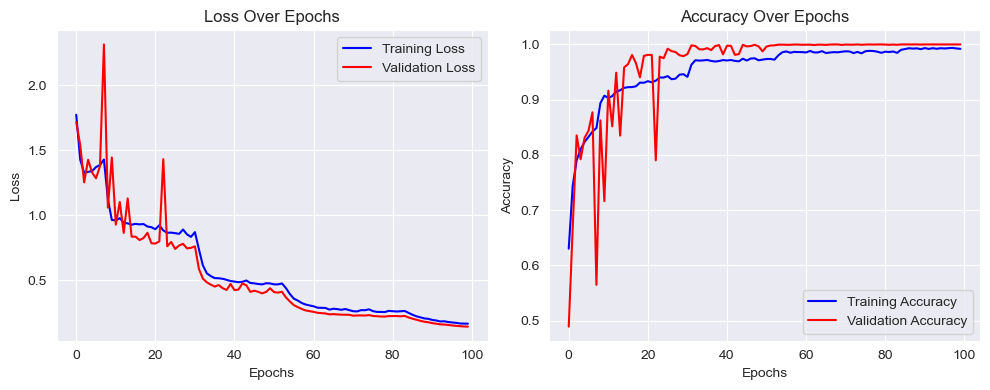

In [21]:
import matplotlib.pyplot as plt

def plot_loss_curves(model_history):
    """Plot training & validation loss and accuracy curves from history object."""

    if not model_history or not hasattr(model_history, "history"):
        print("Invalid history object.")
        return

    # Extract values safely
    loss = model_history.history.get('loss', [])
    val_loss = model_history.history.get('val_loss', [])
    accuracy = model_history.history.get('accuracy', [])
    val_accuracy = model_history.history.get('val_accuracy', [])

    epochs = range(len(loss))

    # Plot loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_loss_curves(history)

2/2 [==============================] - 0s 43ms/step


<Figure size 800x600 with 0 Axes>

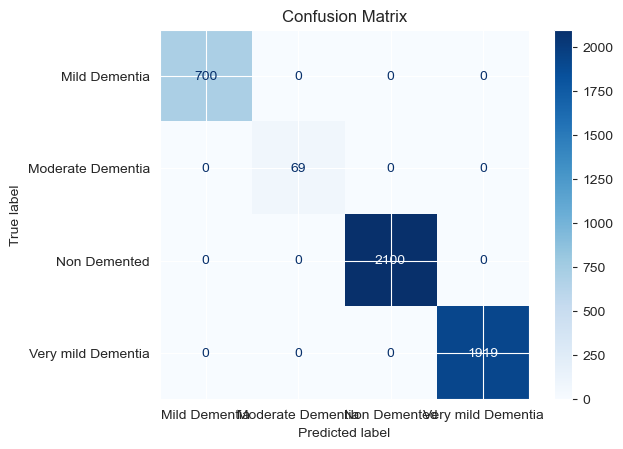

📊 Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       700
 Moderate Dementia       1.00      1.00      1.00        69
      Non Demented       1.00      1.00      1.00      2100
Very mild Dementia       1.00      1.00      1.00      1919

          accuracy                           1.00      4788
         macro avg       1.00      1.00      1.00      4788
      weighted avg       1.00      1.00      1.00      4788

✅ Validation Accuracy: 1.0000


In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# ----------------------------
# Get true labels and predictions
# ----------------------------
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = cnn_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))  # from one-hot/logits to class indices

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ----------------------------
# Classification Report
# ----------------------------
report = classification_report(y_true, y_pred, target_names=classes)
print("📊 Classification Report:\n")
print(report)

# ----------------------------
# Accuracy
# ----------------------------
acc = accuracy_score(y_true, y_pred)
print(f"✅ Validation Accuracy: {acc:.4f}")


In [22]:
# Import model

from tensorflow.keras.models import load_model
# Load the model
cnn_model = load_model("Modelos/FJSL_Alzheimer_Classification_V2.h5")

OSError: No file or directory found at Modelos/FJSL_Alzheimer_Classification_V2.h5

In [ ]:
# Define Paths
dataset_dir = "val_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

In [ ]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image to RGB
    image = tf.image.resize(image, [128, 128])  # Resize to (128, 128)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess a list of images
def load_and_preprocess_images(image_paths):
    # Preprocess all images and store them in a list
    images = [preprocess_image(image_path) for image_path in image_paths]
    
    # Stack the images into a single batch (shape: (batch_size, 128, 128, 3))
    images_batch = tf.stack(images)
    
    return images_batch


test_data = load_and_preprocess_images(image_paths)

# Convert labels to NumPy array
labels = np.array(labels)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true is the actual labels (e.g., integer labels)
y_true = labels  # Actual labels for the test set
predictions = cnn_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

print("True Labels:", y_true)
print("Predicted Labels:", y_pred)

# Classification Report
class_names = classes  # List of class names
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
